In [1]:
import os
import sys
import logging
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as Dataset
import torchvision.transforms.functional as TVF
import torchvision.transforms as transforms
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader , RandomSampler
from torch.nn.utils.rnn import pack_padded_sequence

from torchvision.models import vgg16 , inception_v3 , resnet152 , densenet , densenet121
from PIL import Image

import nltk
nltk.download('punkt')
from gensim.models import Word2Vec , KeyedVectors , FastText

import psutil
import time

[nltk_data] Downloading package punkt to /home/adityarane/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def get_memory_details():
    mem_details = psutil.virtual_memory()
    factor =  1024 * 1024 * 1024
    total = round(mem_details[0] / factor , 2)
    available = round(mem_details[1] / factor , 2)
    used = round(mem_details[3] / factor , 2)
    free = round(mem_details[4] / factor , 2)
    percent_used = mem_details[2]
    print('total : {} GB | available : {} GB | used : {} GB |free : {} GB | Percent Used = {} | Percent free : {}\n'.format(total 
                                                                                                    , available
                                                                                                   , used
                                                                                                   , free
                                                                                                   , percent_used
                                                                                                    , 100 - percent_used))
get_memory_details()

total : 29.46 GB | available : 28.13 GB | used : 0.94 GB |free : 27.77 GB | Percent Used = 4.5 | Percent free : 95.5



In [22]:
dest_path = '/home/adityarane/image_captions/coco/train2017/'
filelist = os.listdir(dest_path)
len(filelist)

150072

In [9]:
source_path = '/home/adityarane/image_captions/flicker30k/flickr30k_images/flickr30k_images/'
f_list = os.listdir(source_path)
len(f_list)

31785

In [21]:
for file_name in f_list:
    if file_name.endswith('.jpg'):
        shutil.copy(source_path+file_name, dest_path+file_name)

In [13]:
!cp -r /home/adityarane/image_captions/flicker30k/flickr30k_images/flickr30k_images/ /home/adityarane/image_captions/coco/train2017/

In [8]:
for file in os.listdir(source_path):
    os.rename(source_path+file, source_path +'flicker30_' + file)

In [28]:
data = pd.read_csv('caption_list.csv', low_memory = False)
data=data[['caption','file_name']]
data.head()

,caption,file_name
0,A bicycle replica with a clock as the front wh...,000000203564.jpg
1,The bike has a clock as a tire.,000000203564.jpg
2,A black metal bicycle with a clock inside the ...,000000203564.jpg
3,A bicycle figurine in which the front wheel is...,000000203564.jpg
4,A clock with the appearance of the wheel of a ...,000000203564.jpg


In [35]:
flicker_data = pd.read_csv('/home/adityarane/image_captions/flicker30k/flickr30k_images/results.csv'
                           , low_memory = False 
                           , sep = '|')
flicker_data.columns = ['file_name','comment_number','caption']
flicker_data['file_name'] = flicker_data['file_name'].apply(lambda x: 'flicker30_' + x)
flicker_data = flicker_data[['caption','file_name']]
flicker_data.head()

,caption,file_name
0,Two young guys with shaggy hair look at their...,flicker30_1000092795.jpg
1,"Two young , White males are outside near many...",flicker30_1000092795.jpg
2,Two men in green shirts are standing in a yard .,flicker30_1000092795.jpg
3,A man in a blue shirt standing in a garden .,flicker30_1000092795.jpg
4,Two friends enjoy time spent together .,flicker30_1000092795.jpg


In [36]:
data.append(flicker_data).to_csv('coco_plus_flicker.csv' , index = False)

In [38]:
data = pd.read_csv('coco_plus_flicker.csv', low_memory = False)
data = data[~(data.caption.isna())]
data['caption'] = data['caption'].str.lower().replace('[^\w\s]','').replace('\.','', regex=True).replace('\,','', regex=True)
data = data.sort_values(by = 'file_name').reset_index(drop = True)
data.shape

(750638, 2)

In [41]:
data.head()

,caption,file_name
0,closeup of bins of food that include broccoli ...,000000000009.jpg
1,a meal is presented in brightly colored plasti...,000000000009.jpg
2,there are containers filled with different kin...,000000000009.jpg
3,colorful dishes holding meat vegetables fruit ...,000000000009.jpg
4,a bunch of trays that have different food,000000000009.jpg


In [42]:
freq_count_dict = {}
sentence_list = []
for sentence in data.caption:
    for word in sentence.lower().strip().split(' '):
        count = freq_count_dict.get(word , 0)
        if count == 0:
            freq_count_dict[word] = 1
        else:
            freq_count_dict[word] = count+1
len(freq_count_dict)

38588

In [47]:
min_count = 8
filtered_vocab = ['<pad>','<sos>','<eos>','<unk>']

for word in freq_count_dict:
    if (freq_count_dict[word] >= min_count):
        filtered_vocab.append(word)
len(filtered_vocab)

10390

In [48]:
word_idx = 0
word_to_idx_dict = {}
idx_to_word_dict = {}
for word in filtered_vocab:
    word_to_idx_dict[word] = word_idx
    idx_to_word_dict[word_idx] = word
    word_idx+=1
vocab_size = len(word_to_idx_dict)
print('word_to_idx_dict : {}'.format(len(word_to_idx_dict)))
print('idx_to_word_dict : {}'.format(len(idx_to_word_dict)))
print('vocab_size : {}'.format(vocab_size))

word_to_idx_dict : 10390
idx_to_word_dict : 10390
vocab_size : 10390


In [49]:
st_time = time.time()
data['length'] = data['caption'].apply(lambda x: min(len(str(x).split(" "))+2,20))
print('records done in {} secs'.format(round(time.time() - st_time , 2)))

records done in 1.18 secs


In [50]:
st_time = time.time()
print_every = 50000
total_records = len(data.index)
seq_length = 20
for i in data.index:
    caption = data.loc[i].caption.split()
    modified_caption = ['<sos>']
    for word in caption:
        if word not in filtered_vocab:
            word = '<unk>'
        else:
            pass
        modified_caption.append(word)
        
    if len(modified_caption) >= seq_length:
        modified_caption = modified_caption[:seq_length-1]
        modified_caption.append('<eos>')
        
    if len(modified_caption) < seq_length:
        modified_caption.append('<eos>')
        for word in range(len(modified_caption) , seq_length):
            modified_caption.append('<pad>')
      
    data.at[i , 'caption'] = ' '.join(tuple(modified_caption))
    if i % print_every == 0:
        print('records done : {}/{} in {} secs'.format(i , total_records , round(time.time() - st_time , 2)))
        st_time = time.time()

records done : 0/750638 in 0.05 secs
records done : 50000/750638 in 67.12 secs
records done : 100000/750638 in 67.02 secs
records done : 150000/750638 in 67.3 secs


KeyboardInterrupt: 

In [ ]:
data = data.sort_values(by = 'length' , ascending = False).reset_index(drop = True)
data.head()

In [ ]:
captions_embed = []
ctr = 0
print_every = 50000
total_records = len(data.index)
st_time = time.time()
data['caption_embed'] = None
for i in data.index:
    description = data.loc[i].caption
    text = description.lower().split(' ')
    encoding = []
    for j in text:
        encoding.append(word_to_idx_dict[j])
    data.at[i ,'caption_embed'] = encoding
    ctr+=1
    if ctr % print_every == 0:
        print('records done : [{}/{}] in {} secs'.format(ctr , total_records , round(time.time() - st_time,2)))
        st_time = time.time()

In [ ]:
data = data[['file_name','caption_embed','length','caption']]
data.values[10000]

In [ ]:
#data.to_csv('data_processed.csv',index = False)
#data = pd.read_csv('data_processed.csv', low_memory = False)
#data.shape

In [ ]:
get_memory_details()

In [17]:
basic_transforms = transforms.Compose([ transforms.CenterCrop(224),
                            transforms.RandomHorizontalFlip(), 
                            transforms.ToTensor(), 
                            transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

In [ ]:
class MyDataset(Dataset):
    def __init__(self, df , foldername , transform=None):
        super(MyDataset, self).__init__()
        self.img_data = df
        self.foldername = foldername
        self.transform = transform
        
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        img_file = self.img_data[index][0]               
        sample = Image.open(self.foldername + img_file).convert('RGB')
        
        if self.transform != None:
            sample = self.transform(sample)
        
        #return sample , torch.tensor(eval(self.img_data[index][1])) , self.img_data[index][2]
        return sample , torch.tensor(self.img_data[index][1]) , self.img_data[index][2]

    def __len__(self):
        return self.img_data.shape[0]
        
train_dataset = MyDataset(df = data.values, foldername = './train2017/' , transform = basic_transforms)

In [8]:
batch_size = 256

In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size = batch_size , shuffle=True)

In [20]:
if torch.cuda.is_available():
    print('GPU available')
    device = torch.device("cuda")
else :
    device = torch.device("cpu")
    print('training on CPU... training will be slow')

GPU available


In [5]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

In [6]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True , enforce_sorted = False) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [11]:
embed_size = 256
hidden_size = 512
encoder_rnn = EncoderCNN(embed_size = embed_size)
decoder_rnn = DecoderRNN(embed_size = embed_size
                         , hidden_size = hidden_size 
                         , vocab_size = vocab_size
                         , num_layers = 1
                        )

In [24]:
epochs = 10
print_every = 10
total_batches = len(train_data_loader)

learning_rate = 0.001
optimizer = torch.optim.Adam([{'params' : encoder_rnn.linear.parameters()}
                              , {'params' : encoder_rnn.bn.parameters()}
                              , {'params' : decoder_rnn.parameters()}], lr = learning_rate)
#loss_fn = F.mse_loss
loss_fn = F.cross_entropy

train_losses = []

encoder_rnn = encoder_rnn.to(device)
decoder_rnn = decoder_rnn.to(device)

for epoch in range(epochs):
    train_losses = []
    st_time  = time.time() 

    for batch in range(total_batches):
    
        image , caption , lengths = next(iter(train_data_loader))
    
        image = image.to(device)
        caption = caption.to(device)
        lengths = lengths.to(device)
        
        optimizer.zero_grad()
        embedding = encoder_rnn(image)
        
        target = pack_padded_sequence(caption, lengths, batch_first=True, enforce_sorted = False)[0]
        y_pred = decoder_rnn(embedding , caption , lengths)
        loss = loss_fn(y_pred , target)
    
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        if batch % print_every == 0:
            print('epoch : [{}/{}] \t batch : [{}/{}] \t train loss : {}\t time : {} sec'.format(epoch 
                                                                                       , epochs
                                                                                       , batch 
                                                                                       ,total_batches
                                                                                       ,loss.item()
                                                                                       #,sum(train_losses)/len(train_losses)
                                                                                      , round(time.time() - st_time,2)))
            st_time  = time.time()
            break

epoch : [0/10] 	 batch : [0/2312] 	 train loss : 9.252466201782227	 time : 19.89 sec
epoch : [1/10] 	 batch : [0/2312] 	 train loss : 9.17080307006836	 time : 18.36 sec
epoch : [2/10] 	 batch : [0/2312] 	 train loss : 9.079087257385254	 time : 17.97 sec
epoch : [3/10] 	 batch : [0/2312] 	 train loss : 8.937108993530273	 time : 17.45 sec
epoch : [4/10] 	 batch : [0/2312] 	 train loss : 8.746936798095703	 time : 16.56 sec
epoch : [5/10] 	 batch : [0/2312] 	 train loss : 8.347111701965332	 time : 17.25 sec
epoch : [6/10] 	 batch : [0/2312] 	 train loss : 7.748014450073242	 time : 17.74 sec
epoch : [7/10] 	 batch : [0/2312] 	 train loss : 7.07631254196167	 time : 17.58 sec
epoch : [8/10] 	 batch : [0/2312] 	 train loss : 6.513493537902832	 time : 18.02 sec
epoch : [9/10] 	 batch : [0/2312] 	 train loss : 6.09212064743042	 time : 16.9 sec


In [10]:
word_to_idx_dict = json.load(open('word_to_idx_dict.json'))
idx_to_word_dict = json.load(open('idx_to_word_dict.json'))
vocab_size = len(word_to_idx_dict)
print('word_to_idx_dict : {}'.format(len(word_to_idx_dict)))
print('idx_to_word_dict : {}'.format(len(idx_to_word_dict)))

word_to_idx_dict : 12878
idx_to_word_dict : 12878


In [12]:
encoder_rnn.load_state_dict(torch.load('/home/adityarane/image_captions/coco/encoder_rnn'))
decoder_rnn.load_state_dict(torch.load('/home/adityarane/image_captions/coco/decoder_rnn'))
device = torch.device("cpu")
encoder_rnn = encoder_rnn.eval().to(device)
decoder_rnn = decoder_rnn.eval().to(device)

In [13]:
folder_name = '/home/adityarane/image_captions/coco/train2017/'
image_list = os.listdir(folder_name)

In [14]:
def get_caption(file_name):
    image = Image.open(file_name).convert('RGB')
    plt.imshow(np.asarray(image))
    embedding = encoder_rnn(basic_transforms(image).unsqueeze(0))
    sampled_ids = decoder_rnn.sample(embedding)
    sampled_ids = sampled_ids[0].cpu().numpy()  
    sampled_caption = []
    for word_id in sampled_ids:
        word = idx_to_word_dict[str(word_id)]
        sampled_caption.append(word)
        if word == '<eos>':
            break
    sentence = ' '.join(sampled_caption)
    print (sentence)

In [19]:
idx = np.random.randint(low = 0 , high = 118287)
file_name = folder_name + image_list[idx]
print(file_name)

/home/adityarane/image_captions/coco/train2017/flicker30_3533452777.jpg


<sos> a plate of food with a fork and knife <eos>


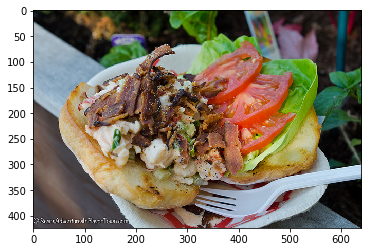

In [28]:
idx = np.random.randint(low = 0 , high = 118287)
file_name = folder_name + image_list[idx]
get_caption(file_name)

<sos> a man and a woman are standing in front of a red backdrop <eos>


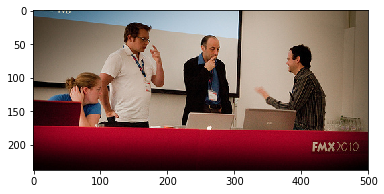

In [29]:
idx = np.random.randint(low = 0 , high =118287)
file_name = folder_name + image_list[idx]
get_caption(file_name)

<sos> a man is standing in a boat with a dog <eos>


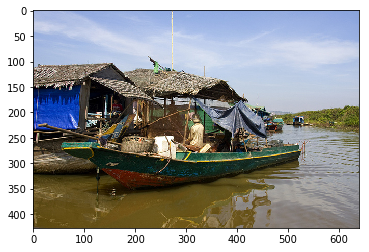

In [30]:
idx = np.random.randint(low = 0 , high =118287)
file_name = folder_name + image_list[idx]
get_caption(file_name)

<sos> a tall building with a clock on the front of it <eos>


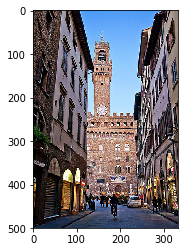

In [32]:
idx = np.random.randint(low = 0 , high =118287)
file_name = folder_name + image_list[idx]
get_caption(file_name)